## Motivation

This project addresses a supervised machine learning classification task: predicting whether White will win in a King and Rook vs. King and Pawn endgame. The target variable is a binary outcome, win or no-win (loss or draw), based on categorical features that encode the board’s positional structure. These endgames, while limited in pieces, remain tactically complex and serve as a useful domain for studying machine learning based prediction.

Chess has long served as a proving ground for algorithmic innovation. The first chess computer, El Ajedrecista, was developed in 1912. It was able to play a perfect King-Rook vs. King endgame. Eighty-five years later, in 1997, IBM’s Deep Blue famously defeated World Champion Garry Kasparov, marking a milestone in computer dominance over human strategy. Since then, engines like Stockfish and AlphaZero have vastly outperformed human play, combining brute-force search with handcrafted heuristics and, more recently, neural-enhanced evaluation. Stockfish achieves near-perfect endgame accuracy through precomputed tablebases and learned scoring functions, showing how data-driven approaches can master structured environments like a chessboard.

This project builds on that tradition by applying logistic regression, support vector machines, and random forests to a dataset of endgame positions, testing how well machine learning techniques can model outcome prediction.

## Exploratory Data Analysis

This project uses the KRKPA7 dataset to investigate how well machine learning models can approximate expert-level reasoning in a chess endgame scenario. The dataset consists of 3,196 legal positions in a King-and-Rook versus King-and-Pawn-on-a7 endgame, where it is always White’s turn to move. Each position is labeled as either “won” or “not won” for White, based on evaluations by expert players. The core challenge is to predict these outcomes using 36 binary features that encode strategic and positional concepts such as skewers, checks, opposition, and promotion threats. These features were designed by domain experts and formalized in Structured Induction in Expert Systems by Alen Shapiro (1987), which framed the problem as a benchmark for interpretable rule learning.

In [55]:
# Package imports

import pandas as pd # Data manipulation
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # Data visualization
from sklearn.decomposition import PCA # PCA plots
from sklearn.model_selection import train_test_split # Train-test split
from sklearn.metrics import accuracy_score # Evaluation metric
from sklearn.preprocessing import StandardScaler # Feature scaling
from sklearn.preprocessing import LabelEncoder # Categorical encoding
from sklearn.pipeline import Pipeline # Model pipeline
from sklearn.model_selection import GridSearchCV # Model comparison
from sklearn.linear_model import LogisticRegression # Logistic regression
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier

In [56]:
# Define the initial column names for the dataset
columns = [
    "bkblk", "bknwy", "bkon8", "bkona", "bkspr", "bkxbq", "bkxcr", "bkxwp", "blxwp", "bxqsq",
    "cntxt", "dsopp", "dwipd", "hdchk", "katri", "mulch", "qxmsq", "r2ar8", "reskd", "reskr",
    "rimmx", "rkxwp", "rxmsq", "simpl", "skach", "skewr", "skrxp", "spcop", "stlmt", "thrsk",
    "wkcti", "wkna8", "wknck", "wkovl", "wkpos", "wtoeg", "class"
]

# Readable column names
readable_column_names = [
    "Black King is not in the way",                               # bkblk
    "Black King not in Black Rook’s way",                         # bknwy
    "Black King on rank 8 aiding Black Rook",                     # bkon8
    "Black King on file A aiding Black Rook",                     # bkona
    "Black King supports Black Rook",                             # bkspr
    "Black King not attacked after promotion",                    # bkxbq
    "Black King can attack b7",                                   # bkxcr
    "Black King can attack White Pawn",                           # bkxwp
    "Black attacks White Pawn (Rook x = -1)",                     # blxwp
    "Black pieces control queening square",                       # bxqsq
    "White King is on edge but not a8",                           # cntxt
    "Kings are in normal opposition",                             # dsopp
    "White King distance to intersect point is too great",        # dwipd
    "Hidden check exists",                                        # hdchk
    "Black King controls intersect point",                        # katri
    "Black can renew check effectively",                          # mulch
    "Mating square attacked by promoted White Pawn",              # qxmsq
    "Black Rook lacks access to file A or rank 8",                # r2ar8
    "White King can be re-skewered later",                        # reskd
    "Black Rook alone can renew skewer",                          # reskr
    "Black Rook can be captured safely",                          # rimmx
    "Black Rook bears on White Pawn (x = -1)",                    # rkxwp
    "Black Rook attacks mating square",                           # rxmsq
    "Simple mating pattern applies",                              # simpl
    "White King can be skewered after checks",                    # skach
    "Potential skewer exists (not fork)",                         # skewr
    "Black Rook skewer or Black King attacks White Pawn",         # skrxp
    "Special opposition pattern present",                         # spcop
    "White King is in stalemate",                                 # stlmt
    "Skewer threat is lurking",                                   # thrsk
    "White King cannot control intersect point",                  # wkcti
    "White King is on a8",                                        # wkna8
    "White King is in check",                                     # wknck
    "White King is overloaded",                                   # wkovl
    "White King in potential skewer position",                    # wkpos
    "White King is one square from the relevant edge",            # wtoeg
    "Game outcome"                                                # class
]

# Load the dataset into a DataFrame
data = pd.read_csv(r"C:\Users\danac\Downloads\chess+king+rook+vs+king+pawn\kr-vs-kp.data",
    header=None,
    names=columns,
    sep=",",
    engine='python'
)

# Apply to your DataFrame
data.columns = readable_column_names

print(data.head())

  Black King is not in the way Black King not in Black Rook’s way  \
0                            f                                  f   
1                            f                                  f   
2                            f                                  f   
3                            f                                  f   
4                            f                                  f   

  Black King on rank 8 aiding Black Rook  \
0                                      f   
1                                      f   
2                                      f   
3                                      f   
4                                      f   

  Black King on file A aiding Black Rook Black King supports Black Rook  \
0                                      f                              f   
1                                      f                              t   
2                                      f                              t   
3                   

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3196 entries, 0 to 3195
Data columns (total 37 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Black King is not in the way                         3196 non-null   object
 1   Black King not in Black Rook’s way                   3196 non-null   object
 2   Black King on rank 8 aiding Black Rook               3196 non-null   object
 3   Black King on file A aiding Black Rook               3196 non-null   object
 4   Black King supports Black Rook                       3196 non-null   object
 5   Black King not attacked after promotion              3196 non-null   object
 6   Black King can attack b7                             3196 non-null   object
 7   Black King can attack White Pawn                     3196 non-null   object
 8   Black attacks White Pawn (Rook x = -1)               3196 non-null   object
 9

C:\Users\danac\AppData\Local\Temp\ipykernel_19888\2033644990.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='Set2')


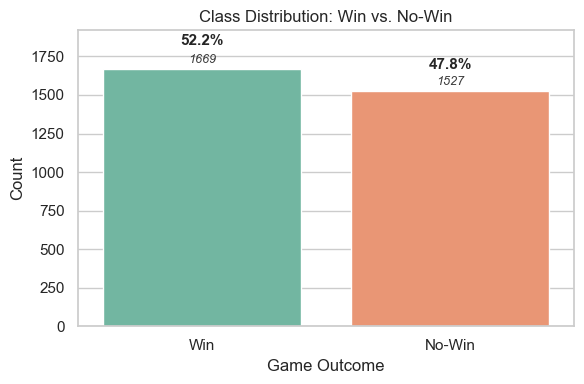

Game outcome
won      0.522215
nowin    0.477785
Name: proportion, dtype: float64

In [58]:
# Calculate class counts and percentages
class_counts = data['Game outcome'].value_counts()
class_percents = (class_counts / class_counts.sum() * 100).round(1)

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='Set2')
for i, (count, percent) in enumerate(zip(class_counts, class_percents)):
    ax.text(i, count * 1.01, f'{count}', ha='center', va='bottom', fontsize=9, style='italic', alpha=0.9)
    ax.text(i, count * 1.08, f'{percent}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Class Distribution: Win vs. No-Win')
plt.xlabel('Game Outcome')
plt.ylabel('Count')
plt.xticks([0, 1], ['Win', 'No-Win'])
plt.ylim(0, max(class_counts) * 1.15)
plt.tight_layout()
plt.show()

data['Game outcome'].value_counts(normalize=True)

The target variable (game outcome) in this dataset is well-balanced with a 52.2%/47.8% win-no-win split.

In [59]:
# Checking data shape
data.shape

(3196, 37)

In [60]:
# Checking for implausible values
data.columns

for col in data.columns:
    unique_vals = data[col].unique()
    print(f"{col}: {unique_vals}")

Black King is not in the way: ['f' 't']
Black King not in Black Rook’s way: ['f' 't']
Black King on rank 8 aiding Black Rook: ['f' 't']
Black King on file A aiding Black Rook: ['f' 't']
Black King supports Black Rook: ['f' 't']
Black King not attacked after promotion: ['f' 't']
Black King can attack b7: ['f' 't']
Black King can attack White Pawn: ['f' 't']
Black attacks White Pawn (Rook x = -1): ['f' 't']
Black pieces control queening square: ['f' 't']
White King is on edge but not a8: ['f' 't']
Kings are in normal opposition: ['f' 't']
White King distance to intersect point is too great: ['l' 'g']
Hidden check exists: ['f' 't']
Black King controls intersect point: ['n' 'w' 'b']
Black can renew check effectively: ['f' 't']
Mating square attacked by promoted White Pawn: ['f' 't']
Black Rook lacks access to file A or rank 8: ['t' 'f']
White King can be re-skewered later: ['f' 't']
Black Rook alone can renew skewer: ['f' 't']
Black Rook can be captured safely: ['f' 't']
Black Rook bears o

The dataset consists of 3,196 rows and 37 columns, comprising 36 features and 1 target variable representing the game outcome. All columns in the dataset are categorical, describing positional or strategic elements of a chess endgame scenario. A review of the dataset confirms that there are no missing values, and no implausible values are present. Each feature is derived from well-defined game mechanics which ensures internal consistency and interpretability across the dataset.

C:\Users\danac\AppData\Local\Temp\ipykernel_19888\3750817502.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = data.drop(columns=["Game outcome"]).applymap(lambda val: value_map.get(val, val))


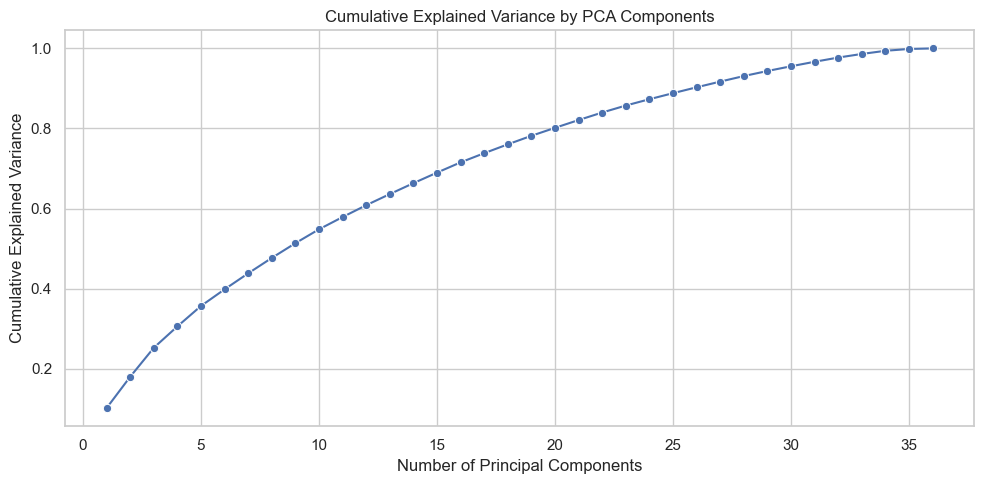

Number of components needed to explain 95% of variance: 30


In [61]:
# Define full mapping
value_map = {
    'f': 0, 't': 1,
    'n': 0, 'g': 0,
    'l': 1, 'w': 1,
    'b': 0 
}

# Encode features numerically
X = data.drop(columns=["Game outcome"]).applymap(lambda val: value_map.get(val, val))
y = data["Game outcome"]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot cumulative variance
plt.figure(figsize=(10, 5))
sns.lineplot(
    x=range(1, len(pca.explained_variance_ratio_) + 1),
    y=pca.explained_variance_ratio_.cumsum(),
    marker='o'
)
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

n_components_95 = (pca.explained_variance_ratio_.cumsum() < 0.95).sum() + 1
print(f"Number of components needed to explain 95% of variance: {n_components_95}")

<Figure size 1000x800 with 0 Axes>

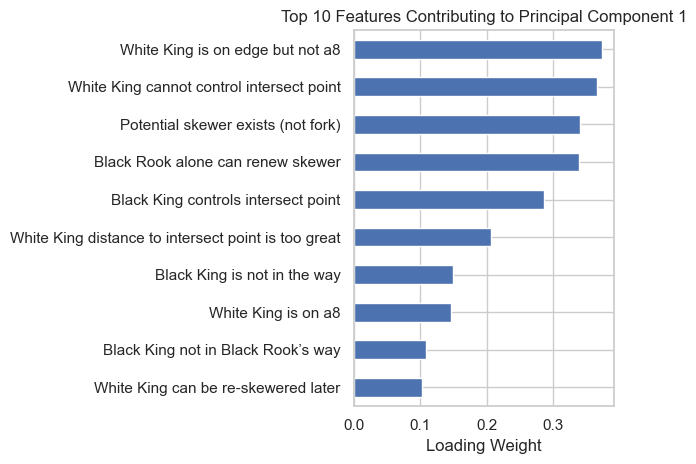

<Figure size 1000x800 with 0 Axes>

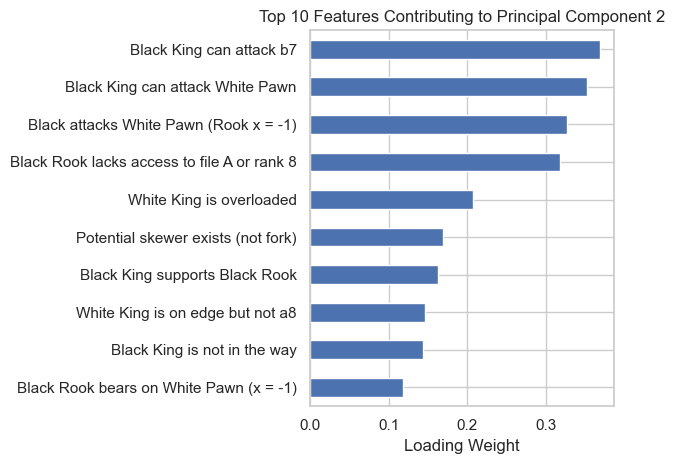

In [62]:
# Get feature names
feature_names = X.columns

loadings = pca.components_.T[:, :2]  # First two components

loading_df = pd.DataFrame(loadings, columns=["PC1", "PC2"], index=feature_names)

# Plot
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
loading_df.sort_values("PC1", ascending=False).head(10).plot(kind="barh", y="PC1", legend=False)
plt.title("Top 10 Features Contributing to Principal Component 1")
plt.xlabel("Loading Weight")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
loading_df.sort_values("PC2", ascending=False).head(10).plot(kind="barh", y="PC2", legend=False)
plt.title("Top 10 Features Contributing to Principal Component 2")
plt.xlabel("Loading Weight")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


The cumulative explained variance plot indicates that around 30 principal components are needed to account for approximately 95% of the dataset's variance, highlighting its high dimensionality. The bar plots for Principal Components 1 and 2 reveal which features contribute most to the major axes of variance: positional and tactical elements involving the White King’s position, skewer threats, and rook safety dominate PC1, while PC2 highlights threats to the Black Rook and final mating patterns. These results help illustrate the positional factors that drive variation in chess endgames, even though PCA is not used in model training.

## Evaluation Metric

I chose accuracy over F1 because the win and no-win classes are balanced and there is no preferred bias on the outcome.

## Model Testing

In [63]:
y = data["Game outcome"]

# Turn t/f into binary
X = pd.get_dummies(data.drop(columns=["Game outcome"]), drop_first=True)

# Encode categorical target
le = LabelEncoder()
y = le.fit_transform(y)
print(f"Target classes: {le.classes_}")

Target classes: ['nowin' 'won']


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
# Logistic Regression

log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='saga'))
])

log_reg_param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [10, 20, 30, 40, 50], 
    'classifier__l1_ratio': [.8, .85, .9, .95, 1],
    'classifier__max_iter': [10000]
}

In [66]:
log_reg_search = GridSearchCV(
    log_reg_pipeline, 
    log_reg_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

log_reg_search.fit(X_train, y_train)
print(f"Best parameters: {log_reg_search.best_params_}")
print(f"Best accuracy score: {log_reg_search.best_score_:.3f}")

Best parameters: {'classifier__C': 20, 'classifier__l1_ratio': 0.95, 'classifier__max_iter': 10000, 'classifier__penalty': 'elasticnet'}
Best accuracy score: 0.976


In [67]:
pd.DataFrame(log_reg_search.cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__l1_ratio,param_classifier__max_iter,param_classifier__penalty,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
9,4.124661,0.351415,0.003113,0.000587,20,1.00,10000,elasticnet,"{'classifier__C': 20, 'classifier__l1_ratio': ...",0.992188,...,0.964844,0.960938,0.980469,0.988235,0.980392,0.976471,0.956863,0.976134,0.010993,1
12,3.806481,0.308016,0.003905,0.001375,30,0.90,10000,elasticnet,"{'classifier__C': 30, 'classifier__l1_ratio': ...",0.992188,...,0.964844,0.960938,0.980469,0.988235,0.980392,0.976471,0.956863,0.976134,0.010993,1
8,4.013959,0.430121,0.004604,0.002161,20,0.95,10000,elasticnet,"{'classifier__C': 20, 'classifier__l1_ratio': ...",0.992188,...,0.964844,0.960938,0.980469,0.988235,0.980392,0.976471,0.956863,0.976134,0.010993,1
16,4.244878,0.861602,0.003614,0.000806,40,0.85,10000,elasticnet,"{'classifier__C': 40, 'classifier__l1_ratio': ...",0.992188,...,0.964844,0.960938,0.980469,0.988235,0.980392,0.976471,0.956863,0.976134,0.010993,1
10,3.797098,0.328268,0.003558,0.001318,30,0.80,10000,elasticnet,"{'classifier__C': 30, 'classifier__l1_ratio': ...",0.992188,...,0.964844,0.957031,0.980469,0.988235,0.980392,0.976471,0.956863,0.975743,0.011580,5
14,3.833807,0.290643,0.003304,0.000748,30,1.00,10000,elasticnet,"{'classifier__C': 30, 'classifier__l1_ratio': ...",0.992188,...,0.964844,0.960938,0.980469,0.988235,0.980392,0.976471,0.956863,0.975743,0.010901,5
13,3.784783,0.279637,0.003067,0.000611,30,0.95,10000,elasticnet,"{'classifier__C': 30, 'classifier__l1_ratio': ...",0.992188,...,0.964844,0.960938,0.980469,0.988235,0.980392,0.976471,0.956863,0.975743,0.010901,5
7,3.800570,0.436538,0.003658,0.001102,20,0.90,10000,elasticnet,"{'classifier__C': 20, 'classifier__l1_ratio': ...",0.992188,...,0.964844,0.957031,0.980469,0.988235,0.980392,0.976471,0.956863,0.975743,0.011580,5
15,3.887628,0.458494,0.003506,0.000806,40,0.80,10000,elasticnet,"{'classifier__C': 40, 'classifier__l1_ratio': ...",0.992188,...,0.964844,0.957031,0.980469,0.988235,0.980392,0.976471,0.956863,0.975743,0.011580,5
22,3.688208,0.304500,0.003910,0.002562,50,0.90,10000,elasticnet,"{'classifier__C': 50, 'classifier__l1_ratio': ...",0.992188,...,0.964844,0.960938,0.980469,0.988235,0.980392,0.976471,0.956863,0.975743,0.010901,5


In [68]:
# Support Vector Classifier 
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

svm_param_grid = [
    {
        'classifier__kernel': ['linear'],
        'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier__kernel': ['poly'],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10],
        'classifier__degree': [2, 3, 4]
    },
    {
        'classifier__kernel': ['rbf'],
        'classifier__C': [5.5, 5.6, 5.7, 5.8, 5.9, 6, 6.1, 6.2, 6.3, 6.4, 6.5],
        'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    }
]

In [69]:
svm_search = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

svm_search.fit(X_train, y_train)
print(f"Best parameters: {svm_search.best_params_}")
print(f"Best accuracy score: {svm_search.best_score_:.3f}")

Best parameters: {'classifier__C': 5.6, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best accuracy score: 0.991


In [70]:
pd.DataFrame(svm_search.cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__kernel,param_classifier__degree,param_classifier__gamma,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
27,0.125810,0.008186,0.025194,0.001683,5.6,rbf,NaN,scale,"{'classifier__C': 5.6, 'classifier__gamma': 's...",0.996094,...,1.0,0.984375,0.988281,1.0,0.988235,0.980392,0.984314,0.991388,0.006742,1
38,0.132624,0.015335,0.027468,0.005170,5.8,rbf,NaN,auto,"{'classifier__C': 5.8, 'classifier__gamma': 'a...",0.996094,...,1.0,0.984375,0.988281,1.0,0.988235,0.980392,0.984314,0.991388,0.006742,1
37,0.125907,0.008178,0.026822,0.001539,5.8,rbf,NaN,scale,"{'classifier__C': 5.8, 'classifier__gamma': 's...",0.996094,...,1.0,0.984375,0.988281,1.0,0.988235,0.980392,0.984314,0.991388,0.006742,1
48,0.126759,0.017865,0.026079,0.002684,6.0,rbf,NaN,auto,"{'classifier__C': 6, 'classifier__gamma': 'aut...",0.996094,...,1.0,0.984375,0.988281,1.0,0.988235,0.980392,0.984314,0.991388,0.006742,1
43,0.134062,0.017694,0.027732,0.003899,5.9,rbf,NaN,auto,"{'classifier__C': 5.9, 'classifier__gamma': 'a...",0.996094,...,1.0,0.984375,0.988281,1.0,0.988235,0.980392,0.984314,0.991388,0.006742,1
32,0.124358,0.011966,0.025263,0.001754,5.7,rbf,NaN,scale,"{'classifier__C': 5.7, 'classifier__gamma': 's...",0.996094,...,1.0,0.984375,0.988281,1.0,0.988235,0.980392,0.984314,0.991388,0.006742,1
57,0.127548,0.013560,0.026091,0.003178,6.2,rbf,NaN,scale,"{'classifier__C': 6.2, 'classifier__gamma': 's...",0.996094,...,1.0,0.988281,0.988281,1.0,0.984314,0.980392,0.984314,0.991386,0.006746,7
52,0.124203,0.009059,0.025654,0.001226,6.1,rbf,NaN,scale,"{'classifier__C': 6.1, 'classifier__gamma': 's...",0.996094,...,1.0,0.988281,0.988281,1.0,0.984314,0.980392,0.984314,0.991386,0.006746,7
63,0.126626,0.015445,0.023979,0.000937,6.3,rbf,NaN,auto,"{'classifier__C': 6.3, 'classifier__gamma': 'a...",0.996094,...,1.0,0.988281,0.988281,1.0,0.984314,0.980392,0.984314,0.991386,0.006746,7
62,0.120306,0.007714,0.023959,0.000813,6.3,rbf,NaN,scale,"{'classifier__C': 6.3, 'classifier__gamma': 's...",0.996094,...,1.0,0.988281,0.988281,1.0,0.984314,0.980392,0.984314,0.991386,0.006746,7


In [71]:
# Random Forest Classification 
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [105, 106, 107, 108, 109, 110],
    'classifier__max_depth': [8, 10, 12, 14],
    'classifier__min_samples_split': [4, 5, 6],  
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': [.62, .625, 0.63, .635, .64]
}

In [72]:
rf_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print(f"Best parameters: {rf_search.best_params_}")
print(f"Best accuracy score: {rf_search.best_score_:.3f}")

Best parameters: {'classifier__max_depth': 10, 'classifier__max_features': 0.625, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 108}
Best accuracy score: 0.993


In [73]:
pd.DataFrame(rf_search.cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
263,0.351448,0.015811,0.010180,0.001100,10,0.630,1,5,110,"{'classifier__max_depth': 10, 'classifier__max...",...,0.992188,0.996094,0.992188,1.0,0.980392,0.984314,0.988235,0.99295,0.006516,1
261,0.358800,0.016665,0.011613,0.001882,10,0.630,1,5,108,"{'classifier__max_depth': 10, 'classifier__max...",...,0.992188,0.996094,0.992188,1.0,0.980392,0.984314,0.988235,0.99295,0.006516,1
262,0.357262,0.018669,0.009830,0.000713,10,0.630,1,5,109,"{'classifier__max_depth': 10, 'classifier__max...",...,0.992188,0.996094,0.992188,1.0,0.980392,0.984314,0.988235,0.99295,0.006516,1
335,0.393675,0.056650,0.010693,0.001536,10,0.640,1,5,110,"{'classifier__max_depth': 10, 'classifier__max...",...,0.992188,0.996094,0.992188,1.0,0.980392,0.984314,0.988235,0.99295,0.006516,1
334,0.378450,0.042515,0.011381,0.003173,10,0.640,1,5,109,"{'classifier__max_depth': 10, 'classifier__max...",...,0.992188,0.996094,0.992188,1.0,0.980392,0.984314,0.988235,0.99295,0.006516,1
226,0.407565,0.020356,0.010185,0.001196,10,0.625,1,5,109,"{'classifier__max_depth': 10, 'classifier__max...",...,0.992188,0.996094,0.992188,1.0,0.980392,0.984314,0.988235,0.99295,0.006516,1
225,0.357111,0.036348,0.010075,0.000790,10,0.625,1,5,108,"{'classifier__max_depth': 10, 'classifier__max...",...,0.992188,0.996094,0.992188,1.0,0.980392,0.984314,0.988235,0.99295,0.006516,1
227,0.367669,0.027699,0.010327,0.001492,10,0.625,1,5,110,"{'classifier__max_depth': 10, 'classifier__max...",...,0.992188,0.996094,0.992188,1.0,0.980392,0.984314,0.988235,0.99295,0.006516,1
333,0.385930,0.027754,0.014835,0.009292,10,0.640,1,5,108,"{'classifier__max_depth': 10, 'classifier__max...",...,0.992188,0.996094,0.992188,1.0,0.980392,0.984314,0.988235,0.99295,0.006516,1
298,0.366056,0.029947,0.010874,0.001416,10,0.635,1,5,109,"{'classifier__max_depth': 10, 'classifier__max...",...,0.992188,0.996094,0.992188,1.0,0.980392,0.984314,0.988235,0.99295,0.006516,1


# Model Comparison

In [74]:
# Model Evaluation and Overfitting Comparison
models = {
    'Logistic Regression': log_reg_search,
    'SVM': svm_search,
    'Random Forest': rf_search,
}

results = pd.DataFrame(columns=['Model', 'Training Set Accuracy', 'Test Set Accuracy'])

for name, model in models.items():
 
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    results.loc[len(results)] = [name, train_accuracy, test_accuracy]

print(results)

results['Gap'] = results['Training Set Accuracy'] - results['Test Set Accuracy']

print(results[['Model', 'Gap']])

                 Model  Training Set Accuracy  Test Set Accuracy
0  Logistic Regression               0.982394           0.962500
1                  SVM               0.998435           0.987500
2        Random Forest               0.995696           0.982812
                 Model       Gap
0  Logistic Regression  0.019894
1                  SVM  0.010935
2        Random Forest  0.012884


# Conclusion

This project finds that the Support Vector Classifier (SVC) model is the best-performing model for predicting outcomes in the chess endgame dataset. It achieved the highest test accuracy (0.9875) while maintaining a minimal generalization gap (0.0109), indicating strong performance and minimal overfitting. In comparison, the Random Forest model performed nearly as well but showed a slightly larger gap between training and test performance, suggesting a higher overfitting tendency. Logistic Regression, while more interpretable and efficient, demonstrated lower predictive performance, likely due to its linear nature being insufficient to capture the complex positional structures encoded in the data.

These results demonstrate the strength of modern classification algorithms in extracting meaningful patterns even from strictly categorical, rule-based systems. The success of SVC in this task suggests that decision boundaries in chess endgames can be effectively learned using kernel-based approaches. Furthermore, the entire modeling pipeline—from feature encoding to cross-validated hyperparameter tuning—highlights the power of supervised learning to capture strategic insights from high-level game state descriptions.

While the SVC model is computationally more intensive than logistic regression, it remains scalable for datasets of this size. However, applying this method to more complex positions involving additional pieces or move history would increase the computational burden significantly. This approach provides a compelling framework for modeling tactical patterns in well-defined, logic-rich environments like chess.

## References 

FBCS, A. L. (2024, September 3). Computer chess: A historical perspective. https://www.bcs.org/articles-opinion-and-research/computer-chess-a-historical-perspective/ 

Peterson, C. (2018, June 11). The effect of endgame tablebases on modern chess engines (CPE 462: Senior Project II). California Polytechnic State University, San Luis Obispo.

Shapiro, A. D. (1987). Structured induction in expert systems. Turing Institute Press in association with Addison-Wesley.